In [1]:
# Use black formatter
# %load_ext lab_black

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
import matplotlib.pyplot as plt

RANDOM_SEED = 123

#### Carga y procesamiento de datos

In [2]:
FILE_PATH = "/tf/notebooks/CEIA-inteligencia_artificial/TP_final/dataset/possum.csv"

original_df = pd.read_csv(FILE_PATH, index_col=0)
df = original_df.copy()
df

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
case,,,,,,,,,,,,,
1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,7,other,m,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
101,7,other,m,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
102,7,other,f,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0


Convertimos las columnas Pop y sex valores numericos 0 o 1 para poder trabajar con ellas. A continuación se muestra como se realizará el encoding.

|  Columna   |    valor   |  Encoding  | 
| :--------: | :--------: | :--------: |
| Pop        | Vic        | 1          |
| Pop        | other      | 0          |
| sex        | m          | 1          |
| sex        | f          | 0          |

In [3]:
pop_binary = pd.get_dummies(df.Pop)
pop_binary.pop("other")
pop_binary.columns = pop_binary.columns.str.lower()
sex_binary = pd.get_dummies(df.sex)
sex_binary.pop("f")

df = df.join([pop_binary, sex_binary])
df.pop("Pop")
df.pop("sex")
df

,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,vic,m
case,,,,,,,,,,,,,
1,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,1,1
2,1,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,1,0
3,1,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,1,0
4,1,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,1,0
5,1,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,7,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0,0,1
101,7,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0,0,1
102,7,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0,0,0


Chequeamos si hay observaciones con valor NaN.

In [4]:
df.isnull().sum()

site        0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
vic         0
m           0
dtype: int64

Como faltan algunos datos en la columna age, cuyos valores son números enteros, no seria buena idea completar con valores como por ejemplo la media, por eso se decide repetir el valor de la columna anterior. Esto se lleva a cabo utilizando el parámetro *method="pad"* en la funcion *fillna*.

In [5]:
df.fillna(method="pad", inplace=True)
df.isnull().sum()

site        0
age         0
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
vic         0
m           0
dtype: int64

### a)

Es una buena práctica realizar primero la división del set de datos en conjuntos de train y test. De esta manera evitamos contaminar accidentalmente el conjunto de entrenamiento con información de test. Si esto sucediese posiblemente los resultados al evaluar el modelo en el set de test arrojarian valores superiores, pero al utilizarse el modelo en producción la performance sería menor.
Debido a que hay 104 muestras una division 80/20 es un buen ratio para los sets de train y test.

In [6]:
X = df.drop("m", axis=1).to_numpy()
y = df["m"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

Se normalizan los datos utilizando StandardScaler. Al tener features con valores de una misma magnitud se le hace más fácil al modelo encontrar una solución adecuada.

In [7]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Modelo 1: Regresión Logística

Se aplica un modelo de regresión logística, entrenado con el conjunto de train. Se decidió utilizar este modelo porque es un problema supervisado, y solo hay dos clases de salida.

In [8]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)

LogisticRegression()

Se calculan las métricas de Accuracy, Precision y Recall para el set de entrenamiento. La métrica de accuracy es buena siempre y cuando el dataset sea balanceado, es decir que no haya mucho mas valores de una clase que de otra.

In [9]:
classes_percentage = np.bincount(y_train) / len(y_train) * 100
print(
    f"El porcentraje de clases es {classes_percentage[0]:.2f}% para la primera y {classes_percentage[1]:.2f}% para la segunda clase"
)

El porcentraje de clases es 40.96% para la primera y 59.04% para la segunda clase


El desbalance de las clases no es tanto, por lo que el valor de accuracy será fiable.

In [10]:
def print_metrics(y_true, y_pred, metrics=None):
    default_metrics = {
        "Accuracy": accuracy_score,
        "Precision": precision_score,
        "Recall": recall_score,
    }
    if metrics is None:
        metrics = default_metrics
    for name, metric in metrics.items():
        result = metric(y_true, y_pred)
        print(f"{name}: {result}")


print("Métricas de entrenamiento:")
print_metrics(y_train, logistic_regression.predict(X_train_scaled))

Métricas de entrenamiento:
Accuracy: 0.7710843373493976
Precision: 0.7884615384615384
Recall: 0.8367346938775511


Se calculan las mismas métricas para el set de test.

In [11]:
y_pred = logistic_regression.predict(X_test_scaled)

print("Métricas de test:")
print_metrics(y_test, logistic_regression.predict(X_test_scaled))

print("\nValores reales de y", y_test)
print("Valores predichos  ", y_pred)

Métricas de test:
Accuracy: 0.6190476190476191
Precision: 0.8333333333333334
Recall: 0.4166666666666667

Valores reales de y [0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
Valores predichos   [1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0]


Los valores de las métricas de test son menores, lo cual es lógico. Y el resultado aunque no es muy bueno es mejor que una predicción aleatoria.

#### Modelo 2: K-means

En este punto debemos utilizar otro modelo de clasificación, sin embargo en clases los otros modelos que hemos estudiado son no supervisados, como K-means o GMM, y al tener un vector de resultados este problema es supervisado. Sin embargo se puede utilizar el modelo K-means para clasificar los datos, y luego comparar con el vector de resultados para evaluar la performance del modelo. Es importante destacar los siguientes puntos:

- Al ser K-means un modelo supervisado no se podra usar el vector de resultados *'y'* para el entrenamiento del modelo.
- A la hora de utilizar métricas para evaluar el modelo debemos ser cuidadosos ya que es posible que los labels asignados por K-means no coincidan con los labels del vector de resultados.

Se utiliza K-means con 2 clusters ya que es un problema de clasificación binaria.

In [12]:
kmeans = KMeans(n_clusters=2, random_state=RANDOM_SEED).fit(X_train_scaled)

print("Métricas de entrenamiento:")
print_metrics(y_train, kmeans.predict(X_train_scaled))

Métricas de entrenamiento:
Accuracy: 0.6626506024096386
Precision: 0.7142857142857143
Recall: 0.7142857142857143


In [13]:
y_pred = kmeans.predict(X_test_scaled)

print("Métricas de test:")
print_metrics(y_test, y_pred)

print("\nValores reales de y", y_test)
print("Valores predichos  ", y_pred)

Métricas de test:
Accuracy: 0.38095238095238093
Precision: 0.4444444444444444
Recall: 0.3333333333333333

Valores reales de y [0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
Valores predichos   [1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0]


La performance del modelo es muy mala, el accuracy es menor a 0.5. Lo que indica que sería mejor predecir la clase contraria a la que predice el modelo.

Quizá el error de clasifiación de K-means se debe a que los valores de los datos estan invertidos. Si esto fuese así los valores reales de accuracy serían:

- Accuracy Train: (1 - 0.662) = 0.338
- Accuracy Test: (1 - 0.380) = 0.620

En este caso el accuracy de test mejora pero el de train empeora, lo cual hace estos resultados no concluyentes.

Para este caso no es buena idea hacer uso de un modelo no supervisado si se conocen los resultados que deseamos predecir. Por lo que es mejor opción utilizar un modelo de Regresión Logística en lugar de K-means.

#### Modelo 3: LDA

Finalemente para tener más puntos de comparación, podemos utilizar un tercer modelo no visto en clase. En este caso utilizaremos Linear Discriminant Analysis (LDA) el cual es un modelo supervisado.

In [14]:
lda = LDA().fit(X_train_scaled, y_train)

print("Métricas de entrenamiento:")
print_metrics(y_train, lda.predict(X_train_scaled))

Métricas de entrenamiento:
Accuracy: 0.7710843373493976
Precision: 0.8125
Recall: 0.7959183673469388


In [15]:
y_pred = lda.predict(X_test_scaled)

print("Métricas de test:")
print_metrics(y_test, y_pred)

print("\nValores reales de y", y_test)
print("Valores predichos  ", y_pred)

Métricas de test:
Accuracy: 0.5714285714285714
Precision: 0.8
Recall: 0.3333333333333333

Valores reales de y [0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
Valores predichos   [0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0]


Las métricas del set de entrenamiento no son muy buenas, pero el accuracy es mayor a 0.5 por lo tanto el modelo sigue siendo mejor que una predicción aleatoria. El modelo de Regresión Logística sigue siendo el que da mejores resultados.

### b)

En este caso tenemos un problema de regresión, por lo que se nos pide predecir una feature que toma valores continuos, totlngth.

Lo primero que debemos hacer es la separación de los datos en conjuntos de entrenamiento y test.

In [16]:
X = df.drop("totlngth", axis=1).to_numpy()
y = df["totlngth"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

#### Modelo 1: Regresión Lineal

Utilizamos PCA para reducir la dimensionalidad de los datos. Esto es necesario para obtener una única feature, con la mayor varianza posible, para utilizar en el modelo de regresión lineal. 

In [17]:
pca = PCA(n_components=1, random_state=RANDOM_SEED).fit(X_train)
X_train_pca = pca.transform(X_train)
print(
    "Se utiliza una componente de PCA, con una varianza de",
    pca.explained_variance_ratio_[0],
)

Se utiliza una componente de PCA, con una varianza de 0.4808074944030742


Graficamos los valores *X_train_pca* en función de *y_train*

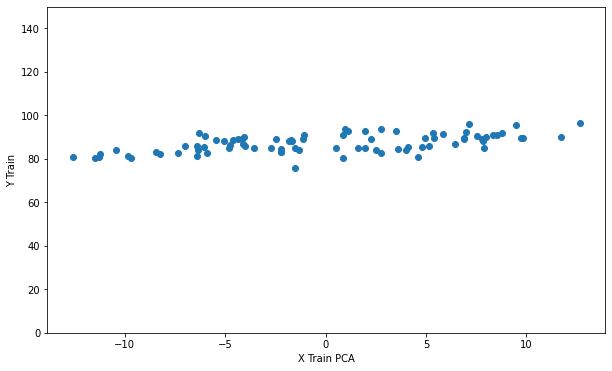

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca, y_train)
plt.xlabel("X Train PCA")
plt.ylabel("Y Train")
plt.ylim((0, 150))
plt.show()

Los datos parecen tener una tendecia lineal, por lo tanto utilizará una recta de la forma *y = mx + b* para ajustar los datos.

In [19]:
scaler = StandardScaler().fit(X_train_pca)
X_train_pca_scaled = scaler.transform(X_train_pca)

In [20]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_pca_scaled, y_train)

LinearRegression()

Para evaluar la performance del modelo utilizamos las métricas MSE y R2.

Métricas de entrenamiento:
MSE: 11.556105203900962
R2: 0.32638119129169696


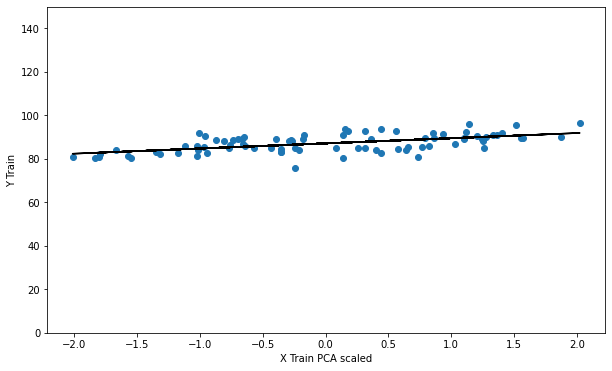

In [21]:
y_pred = linear_regression.predict(X_train_pca_scaled)

metrics = {"MSE": mean_squared_error, "R2": r2_score}

print("Métricas de entrenamiento:")
print_metrics(y_train, y_pred, metrics=metrics)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca_scaled, y_train)
plt.plot(X_train_pca_scaled, linear_regression.predict(X_train_pca_scaled), color="k")
plt.xlabel("X Train PCA scaled")
plt.ylabel("Y Train")
plt.ylim((0, 150))
plt.show()

In [22]:
X_test_pca = pca.transform(X_test)
X_test_pca_scaled = scaler.transform(X_test_pca)

y_pred = linear_regression.predict(X_test_pca_scaled)

print("Métricas de test:")
print_metrics(y_test, y_pred, metrics=metrics)

print("\nValores reales de y", y_test)
print("Valores predichos", y_pred)

Métricas de test:
MSE: 19.344100535259876
R2: 0.170039564523072

Valores reales de y [91.5 88.  89.5 89.  84.  89.  91.5 90.5 89.  88.5 86.5 85.5 94.  87.5
 91.5 75.  82.  77.  81.  91.5 84. ]
Valores predichos [89.02055489 89.42092305 85.50546306 84.5969603  85.5976398  86.78975916
 89.67139675 89.67391887 91.14022823 85.14950199 82.9959582  89.00306877
 90.11441581 84.96392024 90.35499582 86.25006014 83.37771852 85.41210652
 88.06216577 90.08653595 90.07933079]


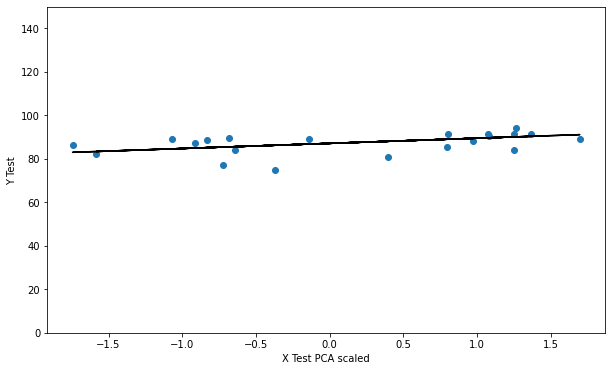

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca_scaled, y_test)
plt.plot(X_test_pca_scaled, y_pred, color="k")
plt.xlabel("X Test PCA scaled")
plt.ylabel("Y Test")
plt.ylim((0, 150))
plt.show()

Como es de esperarse, para los datos de test la performance del modelo es inferior (MSE auemnta y R2 disminuye). Sin embargo, el resultado obtenido es mejor que la media, esto se deduce de que R2 > 0.

#### Modelo 2: Regresión Polinómica

Probamos predecir la columna *totlngth* utilizando regresión polinómica. Para encontrar el grado óptimo del polinomio para ajustar nuestros datos podemos realizar varios polinomios con distintos grados y ver los resultados de MSE y R2 que se obtienen. Realizamos polinmios de grado 1 a 10.

In [24]:
pca = PCA(n_components=0.9, random_state=RANDOM_SEED).fit(X_train)
X_train_pca = pca.transform(X_train)
print(
    f"Se utilizan {pca.n_components_} componentes, los cuales acumulan el 90% de la varianza"
)

Se utilizan 6 componentes, los cuales acumulan el 90% de la varianza


Degree: 1 | MSE train: 6.612 - R2 train: 0.615
Degree: 2 | MSE train: 4.700 - R2 train: 0.726
Degree: 3 | MSE train: 0.000 - R2 train: 1.000
Degree: 4 | MSE train: 0.000 - R2 train: 1.000
Degree: 5 | MSE train: 0.000 - R2 train: 1.000
Degree: 6 | MSE train: 0.000 - R2 train: 1.000
Degree: 7 | MSE train: 0.000 - R2 train: 1.000
Degree: 8 | MSE train: 0.000 - R2 train: 1.000
Degree: 9 | MSE train: 0.000 - R2 train: 1.000
Degree: 10 | MSE train: 0.000 - R2 train: 1.000


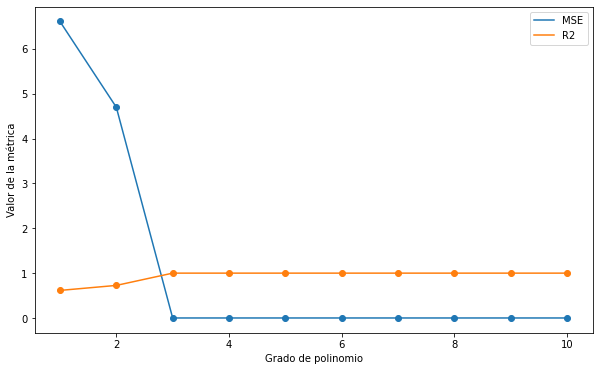

In [25]:
def evauluate_polinomials(
    n_degrees, X_train, y_train, X_test=None, y_test=None, verbose=True
):
    """
    Se evalua la performance de los polinomio de grado 1 a n_degrees
    """
    degrees = [i for i in range(1, n_degrees + 1)]
    mse_train_list = []
    r2_train_list = []
    mse_test_list = []
    r2_test_list = []
    has_test = X_test is not None and y_test is not None

    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X_train)
        linear_regression = LinearRegression().fit(X_poly, y_train)
        y_pred = linear_regression.predict(X_poly)
        mse_train_list.append(mean_squared_error(y_train, y_pred))
        r2_train_list.append(r2_score(y_train, y_pred))

        if has_test:
            X_test_poly = poly.transform(X_test)
            y_pred = linear_regression.predict(X_test_poly)
            mse_test_list.append(mean_squared_error(y_test, y_pred))
            r2_test_list.append(r2_score(y_test, y_pred))

        if verbose:
            message = f"Degree: {degree} | MSE train: {mse_train_list[-1]:.3f} - R2 train: {r2_train_list[-1]:.3f}"
            if has_test:
                message += f" | MSE test: {mse_test_list[-1]:.3f} - R2 test: {r2_test_list[-1]:.3f}"
            print(message)

    if has_test:
        return mse_train_list, r2_train_list, mse_test_list, r2_test_list
    else:
        return mse_train_list, r2_train_list


n_degrees = 10
degrees = [i for i in range(1, n_degrees + 1)]
mse_list, r2_list = evauluate_polinomials(n_degrees, X_train_pca, y_train)

plt.figure(figsize=(10, 6))
plt.scatter(degrees, mse_list)
plt.scatter(degrees, r2_list)
plt.plot(degrees, mse_list, label="MSE")
plt.plot(degrees, r2_list, label="R2")
plt.xlabel("Grado de polinomio")
plt.ylabel("Valor de la métrica")
plt.legend()
plt.show()

Pareciera ser que a medida que crece el grado del polinomio, el modelo mejora, ya que el valor de MSE disminuye y el de R2 aumenta. Para comprobar si esto es cierto realizamos la misma prueba con el set de test.

In [26]:
X_test_pca = pca.transform(X_test)
mse_train_list, r2_train_list, mse_test_list, r2_test_list = evauluate_polinomials(
    n_degrees, X_train_pca, y_train, X_test_pca, y_test
)

Degree: 1 | MSE train: 6.612 - R2 train: 0.615 | MSE test: 8.612 - R2 test: 0.630
Degree: 2 | MSE train: 4.700 - R2 train: 0.726 | MSE test: 19.952 - R2 test: 0.144
Degree: 3 | MSE train: 0.000 - R2 train: 1.000 | MSE test: 260681.133 - R2 test: -11183.548
Degree: 4 | MSE train: 0.000 - R2 train: 1.000 | MSE test: 871.295 - R2 test: -36.383
Degree: 5 | MSE train: 0.000 - R2 train: 1.000 | MSE test: 7152.771 - R2 test: -305.890
Degree: 6 | MSE train: 0.000 - R2 train: 1.000 | MSE test: 37854.108 - R2 test: -1623.134
Degree: 7 | MSE train: 0.000 - R2 train: 1.000 | MSE test: 206425.126 - R2 test: -8855.689
Degree: 8 | MSE train: 0.000 - R2 train: 1.000 | MSE test: 2820580.217 - R2 test: -121016.257
Degree: 9 | MSE train: 0.000 - R2 train: 1.000 | MSE test: 6021188.224 - R2 test: -258338.642
Degree: 10 | MSE train: 0.000 - R2 train: 1.000 | MSE test: 313000467.069 - R2 test: -13429313.197


Al evaluar los modelos sobre los sets de test podemos ver que la suposición de que el modelo mejora al aumentar del grado del polinomio es incorrecta. Todo lo contrario, a medida que el grado es mayor, el modelo empeora en el conjunto de test. Es evidente que hay overfitting para el conjunto de entrenamiento, por esto es que la performance del modelo aumenta con el grado (para el set de entrenamiento). Como conclusión se decide optar por utilizar un polinomio de grado 1. 

In [27]:
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_pca)
linear_regression.fit(X_train_poly, y_train)

X_test_pca = pca.transform(X_test)
X_test_poly = poly.transform(X_test_pca)

y_pred = linear_regression.predict(X_test_poly)

print("Valores reales de y", y_test)
print("Valores predichos", y_pred)

Valores reales de y [91.5 88.  89.5 89.  84.  89.  91.5 90.5 89.  88.5 86.5 85.5 94.  87.5
 91.5 75.  82.  77.  81.  91.5 84. ]
Valores predichos [93.60184273 87.85074325 87.58932956 84.37440907 85.39132148 88.7796644
 87.28450554 88.35541085 89.32923659 83.72679442 82.50798001 87.0619628
 90.85089986 86.05961669 89.27461227 79.73275989 80.36998181 79.32944777
 85.10027072 90.11701477 88.42708917]


Como conclusión para este segundo punto se puede decir que el mejor modelo a utilizar es una regresión polinómica de grado 1, que no es mas que una regresión lineal.